# MovieLens - Predicting a users's gender based on the movies they have watched

...

Summary:

- Prediction type: __Classification model__
- Domain: __Entertainment__
- Prediction target: __The gender of a user__ 
- Population size: __6039__

_Author: Dr. Patrick Urbanke_

# Background

...

It has been downloaded from the [CTU Prague relational learning repository](https://relational.fit.cvut.cz/dataset/MovieLens) (Motl and Schulte, 2015).

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set up your session:

In [1]:
import copy
import os
from urllib import request

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

from sklearn.feature_extraction.text import CountVectorizer

import getml

getml.engine.set_project('MovieLens')


Connected to project 'MovieLens'


Tuning is effective at improving our results, but it takes quite long, so we want to make it optional:

In [2]:
USE_FINE_TUNED = False

## 1. Loading data

### 1.1 Download from source

We begin by downloading the data from the source file:

In [3]:
conn = getml.database.connect_mariadb(
    host="relational.fit.cvut.cz",
    dbname="imdb_MovieLens",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(conn_id='default', dbname='imdb_MovieLens', dialect='mysql', 
           host='relational.fit.cvut.cz', port=3306)

In [4]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(
            name=name,
            table_name=name,
            conn=conn
        )
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [5]:
users = load_if_needed("users")
u2base = load_if_needed("u2base")
movies = load_if_needed("movies")
movies2directors = load_if_needed("movies2directors")
directors = load_if_needed("directors")
movies2actors = load_if_needed("movies2actors")
actors = load_if_needed("actors")

### 1.2 Prepare data for getML

getML requires that we define *roles* for each of the columns.

In [6]:
users["target"] = (users.u_gender == 'F')

In [7]:
users.set_role("userid", getml.data.roles.join_key)
users.set_role("age", getml.data.roles.numerical)
users.set_role("occupation", getml.data.roles.categorical)
users.set_role("target", getml.data.roles.target)

users.save()

Name,userid,target,occupation,age,u_gender
Role,join_key,target,categorical,numerical,unused_string
0,1,1,2,1,F
1,51,1,2,1,F
2,75,1,2,1,F
3,86,1,2,1,F
4,99,1,2,1,F
,...,...,...,...,...
6034,5658,0,5,56,M
6035,5669,0,5,56,M
6036,5703,0,5,56,M


In [8]:
u2base.set_role(["userid", "movieid"], getml.data.roles.join_key)
u2base.set_role("rating", getml.data.roles.numerical)

u2base.save()

Name,userid,movieid,rating
Role,join_key,join_key,numerical
0,2,1964242,1
1,2,2219779,1
2,3,1856939,1
3,4,2273044,1
4,5,1681655,1
,...,...,...
996154,6040,2560616,5
996155,6040,2564194,5
996156,6040,2581228,5


In [9]:
movies.set_role("movieid", getml.data.roles.join_key)
movies.set_role(["year", "runningtime"], getml.data.roles.numerical)
movies.set_role(["isEnglish", "country"], getml.data.roles.categorical)

movies.save()

Name,movieid,isEnglish,country,year,runningtime
Role,join_key,categorical,categorical,numerical,numerical
0,1672052,T,other,3,2
1,1672111,T,other,4,2
2,1672580,T,USA,4,3
3,1672716,T,USA,4,2
4,1672946,T,USA,4,0
,...,...,...,...,...
3827,2591814,T,other,4,2
3828,2592334,T,USA,4,2
3829,2592963,F,France,2,2


In [10]:
movies2directors.set_role(["movieid", "directorid"], getml.data.roles.join_key)
movies2directors.set_role( "genre", getml.data.roles.categorical)

movies2directors.save()

Name,movieid,directorid,genre
Role,join_key,join_key,categorical
0,1672111,54934,Action
1,1672946,188940,Action
2,1679461,179783,Action
3,1691387,291700,Action
4,1693305,14663,Action
,...,...,...
4136,2570825,265215,Other
4137,2572478,149311,Other
4138,2577062,304827,Other


In [11]:
directors.set_role("directorid", getml.data.roles.join_key)
directors.set_role(["d_quality", "avg_revenue"], getml.data.roles.numerical)

directors.save()

Name,directorid,d_quality,avg_revenue
Role,join_key,numerical,numerical
0,67,4,1
1,92,2,3
2,284,4,0
3,708,4,1
4,746,4,4
,...,...,...
2196,305962,4,4
2197,305978,4,2
2198,306168,3,2


In [12]:
movies2actors.set_role(["movieid", "actorid"], getml.data.roles.join_key)
movies2actors.set_role( "cast_num", getml.data.roles.numerical)

movies2actors.save()

Name,movieid,actorid,cast_num
Role,join_key,join_key,numerical
0,1672580,981535,0
1,1672946,1094968,0
2,1673647,149985,0
3,1673647,261595,0
4,1673647,781357,0
,...,...,...
138344,2593313,947005,3
138345,2593313,1090590,3
138346,2593313,1347419,3


In [13]:
actors.set_role("actorid", getml.data.roles.join_key)
actors.set_role("a_quality", getml.data.roles.numerical)
actors.set_role("a_gender", getml.data.roles.categorical)

actors.save()

Name,actorid,a_gender,a_quality
Role,join_key,categorical,numerical
0,4,M,4
1,16,M,0
2,28,M,4
3,566,M,4
4,580,M,4
,...,...,...
98685,2749162,F,3
98686,2749168,F,3
98687,2749204,F,3


In [50]:
movies2actors_movies = movies2actors.join(
    "movies2actors_movies",
    other=actors,
    join_key="actorid"
)

movies2actors_movies = movies2actors_movies.group_by(
    name="movies2actors_movies",
    key="movieid",
    aggregations=[
        movies2actors_movies.cast_num.avg(alias="avg_cast_num"),
        movies2actors_movies.a_quality.avg(alias="avg_a_quality"),
        movies2actors_movies.a_quality.sum(alias="sum_a_quality"),
        (movies2actors_movies.a_gender == 'F').as_num().avg(alias="share_female"),
        (movies2actors_movies.a_gender == 'F').as_num().sum(alias="num_female"),
        ((movies2actors_movies.a_gender == 'F').as_num() * movies2actors_movies.a_quality).sum(alias="weighted_sum"),
        movies2actors_movies.a_gender.count(alias="count_actors")
    ]
)

movies2actors_movies["weighted_share_female"] = movies2actors_movies.weighted_sum / movies2actors_movies.sum_a_quality

movies2actors_movies

Name,movieid,avg_cast_num,avg_a_quality,sum_a_quality,share_female,num_female,weighted_sum,count_actors,weighted_share_female
Role,join_key,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float
0,2593313,2.13793,3.86207,112,0.517241,15,57,29,0.508929
1,2593112,2.4186,3.95349,170,0.232558,10,39,43,0.229412
2,2592963,1.5,4,40,0.2,2,8,10,0.2
3,2592334,2.30556,3.19444,115,0.194444,7,22,36,0.191304
4,2591814,1.70588,3.64706,62,0.235294,4,14,17,0.225806
,...,...,...,...,...,...,...,...,...
3793,2561802,2.32432,3.86486,143,0.27027,10,40,37,0.27972
3794,2562193,2.07407,3.44444,93,0.444444,12,41,27,0.44086
3795,2562411,1.70588,3.41176,58,0.529412,9,30,17,0.517241


In [51]:
movies2actors_movies.set_role(movies2actors_movies.unused_float_names, getml.data.roles.numerical)

movies2actors_movies.save()

Name,movieid,avg_cast_num,avg_a_quality,sum_a_quality,share_female,num_female,weighted_sum,count_actors,weighted_share_female
Role,join_key,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
0,2593313,2.13793,3.86207,112,0.517241,15,57,29,0.508929
1,2593112,2.4186,3.95349,170,0.232558,10,39,43,0.229412
2,2592963,1.5,4,40,0.2,2,8,10,0.2
3,2592334,2.30556,3.19444,115,0.194444,7,22,36,0.191304
4,2591814,1.70588,3.64706,62,0.235294,4,14,17,0.225806
,...,...,...,...,...,...,...,...,...
3793,2561802,2.32432,3.86486,143,0.27027,10,40,37,0.27972
3794,2562193,2.07407,3.44444,93,0.444444,12,41,27,0.44086
3795,2562411,1.70588,3.41176,58,0.529412,9,30,17,0.517241


We need to separate our data set into a training, testing and validation set:

In [16]:
random = users.random()

is_training = (random < 0.75)
is_test = ~is_training

data_train = users.where("data_train", is_training)
data_test = users.where("data_test", is_test)

## 2. Predictive modelling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

### 2.1 Define relational model

To get started with relational learning, we need to specify the data model.

In [17]:
users_ph = getml.data.Placeholder('users')
u2base_ph = getml.data.Placeholder('u2base')
movies_ph = getml.data.Placeholder('movies')
movies2directors_ph = getml.data.Placeholder('movies2directors')
directors_ph = getml.data.Placeholder('directors')
movies2actors_movies_ph = getml.data.Placeholder('movies2actors_movies')

users_ph.join(
    u2base_ph,
    join_key='userid'
)

u2base_ph.join(
    movies_ph,
    join_key='movieid',
    relationship=getml.data.relationship.many_to_one
)

#movies_ph.join(
#    movies2directors_ph,
#    join_key='movieid'
#)

movies2directors_ph.join(
    directors_ph,
    join_key='directorid',
    relationship=getml.data.relationship.many_to_one
)

movies_ph.join(
    movies2actors_movies_ph,
    join_key='movieid',
    relationship=getml.data.relationship.many_to_one
)

users_ph

placeholder      other placeholder   allow lagged targets   horizon   join keys used   ...   
users         u2base                 False                  0.0       userid           ...   
u2base        movies                 False                  0.0       movieid          ...   
movies        movies2actors_movies   False                  0.0       movieid          ...   



other join keys used   other time stamps used   relationship   time stamps used   
userid                                          many-to-many                      
movieid                                         many-to-one                       
movieid                                         many-to-one                       



other join keys used   upper time stamps used   
userid                                          
movieid                                         
movieid

### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We can either use the relboost default parameters or some more fine-tuned parameters. Fine-tuning these parameters in this way can increase our predictive accuracy to 85%, but the training time increases to over 4 hours. We therefore assume that we want to use the default parameters.

In [52]:
relboost = getml.feature_learning.RelMTModel(
    num_features=10,
    num_subfeatures=5,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    seed=4367,
    num_threads=1
)

predictor = getml.predictors.XGBoostClassifier()

__Build the pipeline__

In [56]:
peripheral_ph = [
    u2base_ph, 
    movies_ph, 
    movies2directors_ph, 
    directors_ph, 
    movies2actors_movies_ph
]

pipe = getml.pipeline.Pipeline(
    tags=['relmt'],
    population=users_ph,
    peripheral=peripheral_ph,
    feature_learners=[relboost],
    #feature_selectors=[feature_selector],
    predictors=[predictor]
)

### 2.3 Model training

In [20]:
peripheral = {
    "u2base": u2base, 
    "movies": movies, 
    "movies2directors": movies2directors,
    "directors": directors,
    "movies2actors_movies": movies2actors_movies
}

In [21]:
pipe.check(data_train, peripheral)

Checking data model...
OK.


In [57]:
pipe.fit(data_train, peripheral)

Checking data model...
OK.

Retrieving features (because a similar feature learner has already been fitted)...
[========================================] 100%

RelMT: Building features...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:2.599881



Pipeline(preprocessors=[], feature_learners=['RelMTModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['u2base', 'movies', 'movies2directors', 'directors', 'movies2actors_movies'], 
         population='users', predictors=['XGBoostClassifier'], tags=['relmt'], 
         share_selected_features=0.5)

url: http://localhost:1709/#/getpipeline/MovieLens/TNJEyg/0/

### 2.4 Model evaluation

In [58]:
pipe.score(data_test, peripheral)


RelMT: Building features...
[========================================] 100%



,date time,set used,target,accuracy,auc,cross entropy
0,2021-01-06 00:37:13,data_train,target,0.83790,0.89227,0.36563
1,2021-01-06 00:37:18,data_test,target,0.80079,0.83221,0.44207


### 2.6 Studying features

__Feature correlations__

We want to analyze how the features are correlated with the target variable.

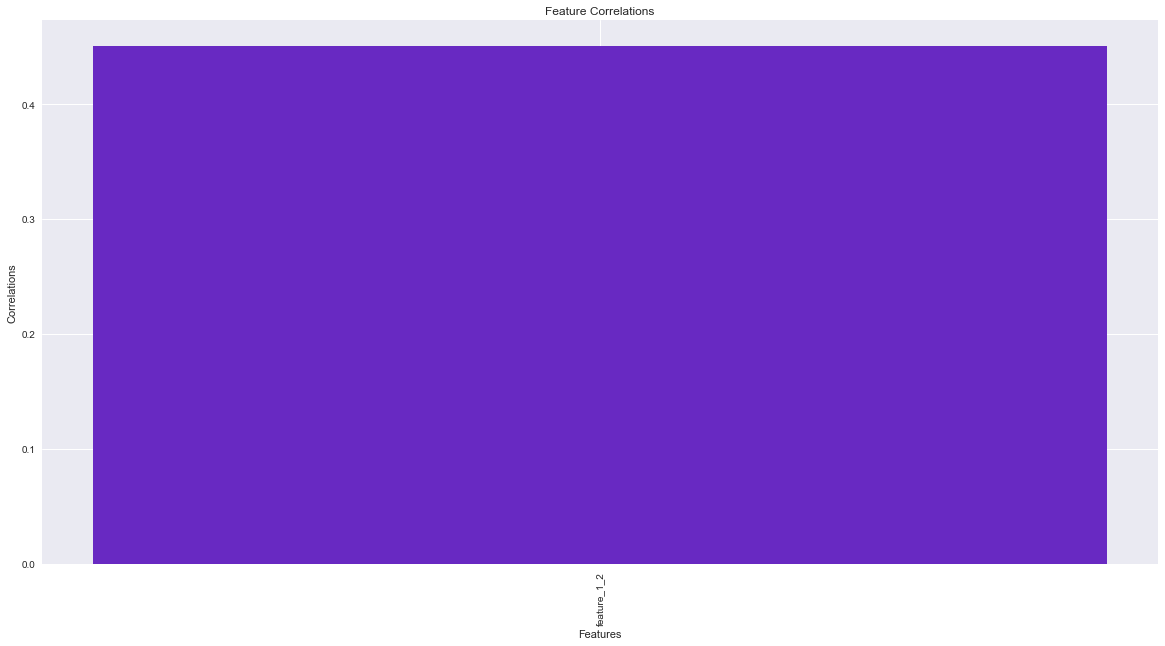

In [24]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title('Feature Correlations')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

In [25]:
pipe.features.to_sql()

```sql
DROP TABLE IF EXISTS "FEATURE_1_2";

CREATE TABLE "FEATURE_1_2" AS
SELECT AVG( 
    CASE
        WHEN ( t4."share_female" > 0.381295 ) AND ( t4."AVG_cast_num" > 2.336732 ) THEN COALESCE( t1."age" - 30.71256038647343, 0.0 ) * -0.1640299362326539 + COALESCE( t2."rating" - 3.573428476587708, 0.0 ) * 3.63063700446265 + COALESCE( t3."year" - 3.634615265667814, 0.0 ) * -4.003393040761372 + COALESCE( t3."runningtime" - 2.316290155312222, 0.0 ) * 1.843260118449555 + COALESCE( t4."num_female" - 12.47199823513524, 0.0 ) * 0.5678403348865059 + COALESCE( t4."COUNT_actors" - 43.92090890535088, 0.0 ) * -0.6507091016752605 + COALESCE( t4."AVG_cast_num" - 2.174432172040184, 0.0 ) * 42.21754547528068 + COALESCE( t4."AVG_a_quality" - 3.585857796748144, 0.0 ) * -4.751761317888637 + COALESCE( t4."share_female" - 0.2845349121667481, 0.0 ) * -16.67709862228532 + 2.0897064768174999e-02
        WHEN ( t4."share_female" > 0.381295 ) AND ( t4."AVG_cast_num" <= 2.336732 OR t4."AVG_cast_num" IS NULL ) THEN COALESCE( t1."age" - 30.71256038647343, 0.0 ) * -0.08789574061165577 + COALESCE( t2."rating" - 3.573428476587708, 0.0 ) * 0.1123071435585898 + COALESCE( t3."year" - 3.634615265667814, 0.0 ) * -2.519298571306062 + COALESCE( t3."runningtime" - 2.316290155312222, 0.0 ) * 3.100743682674741 + COALESCE( t4."num_female" - 12.47199823513524, 0.0 ) * 0.384146433327175 + COALESCE( t4."COUNT_actors" - 43.92090890535088, 0.0 ) * -0.2570369573406673 + COALESCE( t4."AVG_cast_num" - 2.174432172040184, 0.0 ) * -4.894825566399654 + COALESCE( t4."AVG_a_quality" - 3.585857796748144, 0.0 ) * 1.705966037423575 + COALESCE( t4."share_female" - 0.2845349121667481, 0.0 ) * -23.16192420158488 + 1.2014972103599706e-02
        WHEN ( t4."share_female" <= 0.381295 OR t4."share_female" IS NULL ) AND ( t4."COUNT_actors" > 75.000000 ) THEN COALESCE( t1."age" - 30.71256038647343, 0.0 ) * 0.06822522772047232 + COALESCE( t2."rating" - 3.573428476587708, 0.0 ) * 0.2740718972362705 + COALESCE( t3."year" - 3.634615265667814, 0.0 ) * -4.500351649334385 + COALESCE( t3."runningtime" - 2.316290155312222, 0.0 ) * 9.486814766315385 + COALESCE( t4."num_female" - 12.47199823513524, 0.0 ) * 0.2105348674114316 + COALESCE( t4."COUNT_actors" - 43.92090890535088, 0.0 ) * -0.1096448607941439 + COALESCE( t4."AVG_cast_num" - 2.174432172040184, 0.0 ) * -3.973459930615083 + COALESCE( t4."AVG_a_quality" - 3.585857796748144, 0.0 ) * 3.197558808200108 + COALESCE( t4."share_female" - 0.2845349121667481, 0.0 ) * 15.45354763362947 + -1.8342370206178040e-02
        WHEN ( t4."share_female" <= 0.381295 OR t4."share_female" IS NULL ) AND ( t4."COUNT_actors" <= 75.000000 OR t4."COUNT_actors" IS NULL ) THEN COALESCE( t1."age" - 30.71256038647343, 0.0 ) * 0.01856235930965308 + COALESCE( t2."rating" - 3.573428476587708, 0.0 ) * -0.4524474923247442 + COALESCE( t3."year" - 3.634615265667814, 0.0 ) * 0.6955614237954107 + COALESCE( t3."runningtime" - 2.316290155312222, 0.0 ) * -0.06870092208719955 + COALESCE( t4."num_female" - 12.47199823513524, 0.0 ) * 0.02534104864847198 + COALESCE( t4."COUNT_actors" - 43.92090890535088, 0.0 ) * 0.02435536120432719 + COALESCE( t4."AVG_cast_num" - 2.174432172040184, 0.0 ) * -1.976922202041517 + COALESCE( t4."AVG_a_quality" - 3.585857796748144, 0.0 ) * 0.4932388751627604 + COALESCE( t4."share_female" - 0.2845349121667481, 0.0 ) * 12.80047232844098 + -5.1692061616123832e-03
        ELSE NULL
    END
) AS "feature_1_2",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t4
ON t3."movieid" = t4."movieid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURES";

CREATE TABLE "FEATURES" AS
SELECT        CAST( COALESCE( f_1_2."feature_1_2", 0.0 ) AS REAL ) AS "feature_1_2",
CAST( t1."target" AS REAL ) AS "target_1__target"
FROM "users" t1
LEFT JOIN "FEATURE_1_2" f_1_2
ON t1.rowid = f_1_2."rownum"
ORDER BY t1.rowid;

DROP TABLE IF EXISTS "FEATURE_1_2";

```

__Feature importances__
 
Feature importances are calculated by analyzing the improvement in predictive accuracy on each node of the trees in the XGBoost predictor. They are then normalized, so that all importances add up to 100%.

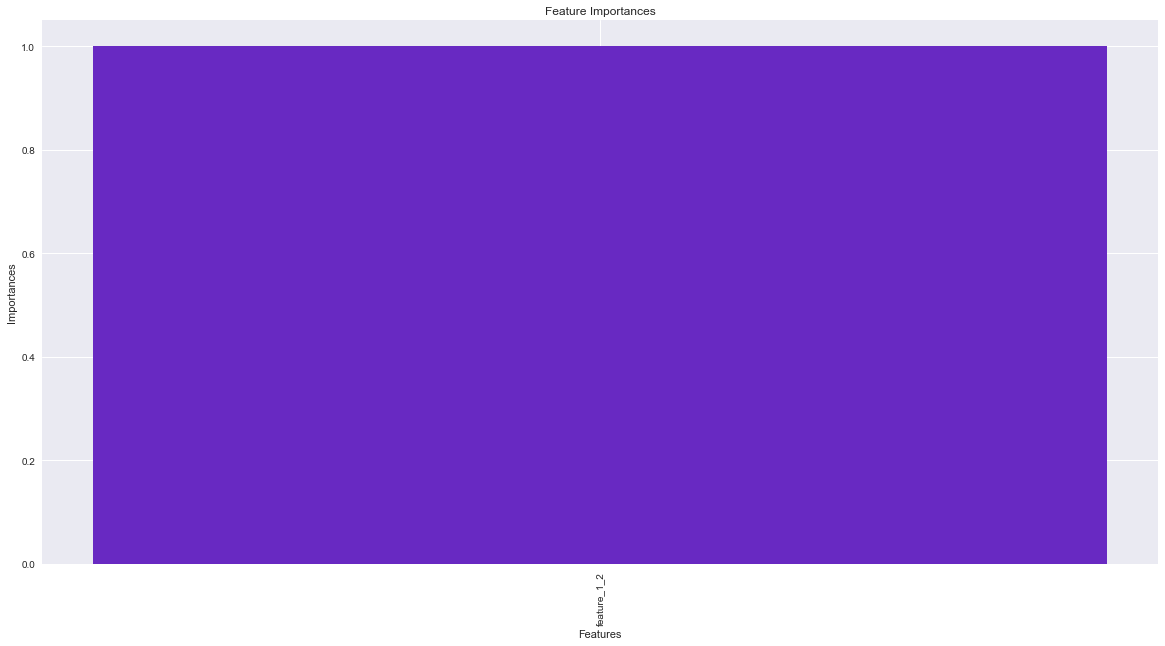

In [26]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

__Column importances__

Because getML uses relational learning, we can apply the principles we used to calculate the feature importances to individual columns as well.

As we can see, most of the predictive accuracy is drawn from the roles played by the actors. This suggests that the text fields contained in this relational database have a higher impact on predictive accuracy than for most other data sets.

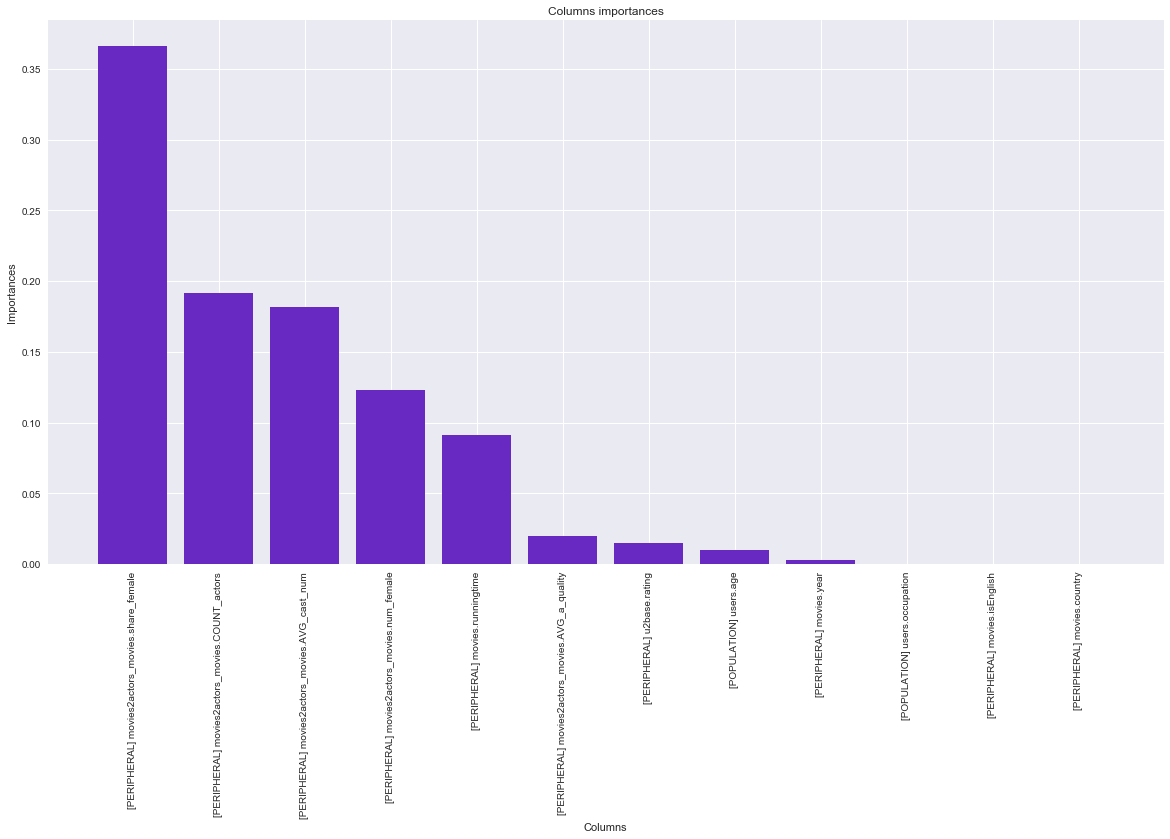

In [27]:
names, importances = pipe.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Columns importances')
plt.xlabel('Columns')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

__Transpiling the learned features__

We can also transpile the learned features to SQLite3 code. We want to show the two most important features. That is why we call the `.features.importances().` method again. The names that are returned are already sorted by importance.

In [28]:
names, _ = pipe.features.importances()

pipe.features.to_sql()

```sql
DROP TABLE IF EXISTS "FEATURE_1_2";

CREATE TABLE "FEATURE_1_2" AS
SELECT AVG( 
    CASE
        WHEN ( t4."share_female" > 0.381295 ) AND ( t4."AVG_cast_num" > 2.336732 ) THEN COALESCE( t1."age" - 30.71256038647343, 0.0 ) * -0.1640299362326539 + COALESCE( t2."rating" - 3.573428476587708, 0.0 ) * 3.63063700446265 + COALESCE( t3."year" - 3.634615265667814, 0.0 ) * -4.003393040761372 + COALESCE( t3."runningtime" - 2.316290155312222, 0.0 ) * 1.843260118449555 + COALESCE( t4."num_female" - 12.47199823513524, 0.0 ) * 0.5678403348865059 + COALESCE( t4."COUNT_actors" - 43.92090890535088, 0.0 ) * -0.6507091016752605 + COALESCE( t4."AVG_cast_num" - 2.174432172040184, 0.0 ) * 42.21754547528068 + COALESCE( t4."AVG_a_quality" - 3.585857796748144, 0.0 ) * -4.751761317888637 + COALESCE( t4."share_female" - 0.2845349121667481, 0.0 ) * -16.67709862228532 + 2.0897064768174999e-02
        WHEN ( t4."share_female" > 0.381295 ) AND ( t4."AVG_cast_num" <= 2.336732 OR t4."AVG_cast_num" IS NULL ) THEN COALESCE( t1."age" - 30.71256038647343, 0.0 ) * -0.08789574061165577 + COALESCE( t2."rating" - 3.573428476587708, 0.0 ) * 0.1123071435585898 + COALESCE( t3."year" - 3.634615265667814, 0.0 ) * -2.519298571306062 + COALESCE( t3."runningtime" - 2.316290155312222, 0.0 ) * 3.100743682674741 + COALESCE( t4."num_female" - 12.47199823513524, 0.0 ) * 0.384146433327175 + COALESCE( t4."COUNT_actors" - 43.92090890535088, 0.0 ) * -0.2570369573406673 + COALESCE( t4."AVG_cast_num" - 2.174432172040184, 0.0 ) * -4.894825566399654 + COALESCE( t4."AVG_a_quality" - 3.585857796748144, 0.0 ) * 1.705966037423575 + COALESCE( t4."share_female" - 0.2845349121667481, 0.0 ) * -23.16192420158488 + 1.2014972103599706e-02
        WHEN ( t4."share_female" <= 0.381295 OR t4."share_female" IS NULL ) AND ( t4."COUNT_actors" > 75.000000 ) THEN COALESCE( t1."age" - 30.71256038647343, 0.0 ) * 0.06822522772047232 + COALESCE( t2."rating" - 3.573428476587708, 0.0 ) * 0.2740718972362705 + COALESCE( t3."year" - 3.634615265667814, 0.0 ) * -4.500351649334385 + COALESCE( t3."runningtime" - 2.316290155312222, 0.0 ) * 9.486814766315385 + COALESCE( t4."num_female" - 12.47199823513524, 0.0 ) * 0.2105348674114316 + COALESCE( t4."COUNT_actors" - 43.92090890535088, 0.0 ) * -0.1096448607941439 + COALESCE( t4."AVG_cast_num" - 2.174432172040184, 0.0 ) * -3.973459930615083 + COALESCE( t4."AVG_a_quality" - 3.585857796748144, 0.0 ) * 3.197558808200108 + COALESCE( t4."share_female" - 0.2845349121667481, 0.0 ) * 15.45354763362947 + -1.8342370206178040e-02
        WHEN ( t4."share_female" <= 0.381295 OR t4."share_female" IS NULL ) AND ( t4."COUNT_actors" <= 75.000000 OR t4."COUNT_actors" IS NULL ) THEN COALESCE( t1."age" - 30.71256038647343, 0.0 ) * 0.01856235930965308 + COALESCE( t2."rating" - 3.573428476587708, 0.0 ) * -0.4524474923247442 + COALESCE( t3."year" - 3.634615265667814, 0.0 ) * 0.6955614237954107 + COALESCE( t3."runningtime" - 2.316290155312222, 0.0 ) * -0.06870092208719955 + COALESCE( t4."num_female" - 12.47199823513524, 0.0 ) * 0.02534104864847198 + COALESCE( t4."COUNT_actors" - 43.92090890535088, 0.0 ) * 0.02435536120432719 + COALESCE( t4."AVG_cast_num" - 2.174432172040184, 0.0 ) * -1.976922202041517 + COALESCE( t4."AVG_a_quality" - 3.585857796748144, 0.0 ) * 0.4932388751627604 + COALESCE( t4."share_female" - 0.2845349121667481, 0.0 ) * 12.80047232844098 + -5.1692061616123832e-03
        ELSE NULL
    END
) AS "feature_1_2",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t4
ON t3."movieid" = t4."movieid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURES";

CREATE TABLE "FEATURES" AS
SELECT        CAST( COALESCE( f_1_2."feature_1_2", 0.0 ) AS REAL ) AS "feature_1_2",
CAST( t1."target" AS REAL ) AS "target_1__target"
FROM "users" t1
LEFT JOIN "FEATURE_1_2" f_1_2
ON t1.rowid = f_1_2."rownum"
ORDER BY t1.rowid;

DROP TABLE IF EXISTS "FEATURE_1_2";

```

In [29]:
names, _ = pipe.features.importances()

pipe.features.to_sql()[names[1]]

IndexError: index 1 is out of bounds for axis 0 with size 1

### 2.7 Benchmarks

## 3. Conclusion

In this notebook we have demonstrated how getML can be applied to text fields. We have demonstrated the our  approach outperforms state-of-the-art relational learning algorithms on the IMdb dataset.

## Citations

Motl, Jan, and Oliver Schulte. "The CTU prague relational learning repository." arXiv preprint arXiv:1511.03086 (2015).
    
Neville, Jennifer, and David Jensen. "Relational dependency networks." Journal of Machine Learning Research 8.Mar (2007): 653-692.
    
Neville, Jennifer, and David Jensen. "Collective classification with relational dependency networks." Workshop on Multi-Relational Data Mining (MRDM-2003). 2003.
    
Neville, Jennifer, et al. "Learning relational probability trees." Proceedings of the Ninth ACM SIGKDD international conference on Knowledge discovery and data mining. 2003.
    
Perovšek, Matic, et al. "Wordification: Propositionalization by unfolding relational data into bags of words." Expert Systems with Applications 42.17-18 (2015): 6442-6456.

# Next Steps

This tutorial went through the basics of applying getML to relational data. If you want to learn more about getML, here are some additional tutorials and articles that will help you:

__Tutorials:__
* [Loan default prediction: Introduction to relational learning](loans_demo.ipynb)
* [Occupancy detection: A multivariate time series example](occupancy_demo.ipynb)  
* [Expenditure categorization: Why relational learning matters](consumer_expenditures_demo.ipynb)
* [Disease lethality prediction: Feature engineering and the curse of dimensionality](atherosclerosis_demo.ipynb)
* [Traffic volume prediction: Feature engineering on multivariate time series](interstate94_demo.ipynb)
* [Air pollution prediction: Why feature learning outperforms brute-force approaches](air_pollution_demo.ipynb) 


__User Guides__ (from our [documentation](https://docs.getml.com/latest/)):
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)


# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.